## UniFi: A Unified Framework for Portfolio Management Demo

In [81]:
%load_ext autoreload
%autoreload 2

### Imports packages

In [213]:
from sys import path
from os.path import dirname as dir
path.append(dir(path[0]))
from statistics import median
from AgentLayer.ConventionalAgents.LRAgent import LRAgent
from AgentLayer.ConventionalAgents.SVRAgent import SVRAgent
from AgentLayer.DataSplitter.TimeSeriesSplitter import TimeSeriesSplitter
from FinancialDataLayer.DataCollection.DataDownloader import DataDownloader
from FinancialDataLayer.DataProcessing.DefaultFeatureEngineer import DefaultFeatureEngineer
from EvaluationLayer.PortfolioEvaluator import PortfolioEvaluator
from AgentLayer.RLAgents.A2C import A2C
from AgentLayer.Environment.PortfolioEnv import PortfolioEnv
import yaml
import numpy as np
from AgentLayer.metrics import *

### Import user parameters

In [121]:
# IMPORT .yaml FILE
# Gather user parameters
with open("..//user_params.yaml", "r") as stream:
    try:
        user_params = yaml.safe_load(stream)
    except yaml.YAMLError as exc:
        print(exc)

tickers = user_params["TICKERS"]
tech_indicator_list = user_params["FEATURE_ENG_PARAMS"]["tech_indicator_list"]
feature_eng_params = user_params["FEATURE_ENG_PARAMS"]
env_kwargs = user_params["ENV_PARAMS"]
train_params = user_params["TRAIN_PARAMS"]
policy_params = user_params["POLICY_PARAMS"]
test_params = user_params["TEST_PARAMS"]
feature_list = env_kwargs["feature_list"]
train_start = user_params["TRAIN_START_DATE"]
train_end = user_params["TRAIN_END_DATE"]
trade_start = user_params["TRADE_START_DATE"]
trade_end = user_params["TRADE_END_DATE"]

In [122]:
tech_indicator_list

['macd',
 'boll_ub',
 'boll_lb',
 'rsi_30',
 'cci_30',
 'dx_30',
 'close_30_sma',
 'close_60_sma']

In [123]:
feature_list

['macd',
 'boll_ub',
 'boll_lb',
 'rsi_30',
 'cci_30',
 'dx_30',
 'close_30_sma',
 'close_60_sma',
 'close']

In [124]:
train_params["A2C_PARAMS"]

{'total_timesteps': 100000,
 'callback': None,
 'log_interval': 100,
 'eval_env': None,
 'eval_freq': -1,
 'n_eval_episodes': 5,
 'tb_log_name': 'A2C',
 'eval_log_path': None,
 'reset_num_timesteps': True}

In [125]:
env_kwargs

{'hmax': 100,
 'initial_amount': 1000000,
 'transaction_cost_pct': 0.001,
 'state_space': 4,
 'stock_dim': 4,
 'feature_list': ['macd',
  'boll_ub',
  'boll_lb',
  'rsi_30',
  'cci_30',
  'dx_30',
  'close_30_sma',
  'close_60_sma',
  'close'],
 'action_space': 4,
 'reward_scaling': 0.1}

### Download data

In [126]:
# FETCH DATA
downloaded_df = DataDownloader(start_date=train_start,
                                end_date=trade_end,
                                ticker_list=tickers).download_from_yahoo()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (8432, 8)


In [127]:
downloaded_df.head()

,date,open,high,low,close,volume,tic,day
0,2007-12-31,7.125000,7.160714,7.062500,6.048641,539333200,AAPL,0
1,2007-12-31,88.139999,88.279999,87.239998,64.097244,3184200,BA,0
2,2007-12-31,73.000000,73.709999,72.389999,48.465931,2639600,CAT,0
3,2007-12-31,94.370003,94.580002,93.010002,53.035412,5086600,CVX,0
4,2008-01-02,7.116786,7.152143,6.876786,5.949702,1079178800,AAPL,2


### Preprocess Data

In [128]:
data_processor = DefaultFeatureEngineer(**feature_eng_params)
# add technical indicators as features
df_processed = data_processor.extend_data(downloaded_df)

Successfully added technical indicators
Successfully added covariances
Successfully added returns


In [129]:
df_processed.head()

,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,cov_list,return_list
0,2009-12-30,AAPL,7.458214,7.571429,7.439643,6.462714,412084400.0,2.0,0.095174,6.478916,5.641879,61.152161,150.672054,28.405596,6.101846,6.037638,"[[0.00045722578356110783, 0.000256460404833502...",tic AAPL BA CAT ...
0,2009-12-30,BA,54.860001,55.290001,54.750000,42.826870,2461000.0,2.0,0.536568,43.969530,41.723188,56.637320,46.516444,5.646709,42.169462,40.660286,"[[0.00045722578356110783, 0.000256460404833502...",tic AAPL BA CAT ...
0,2009-12-30,CAT,57.980000,58.220001,57.750000,41.561859,3479800.0,2.0,0.111334,42.411626,40.378466,54.616400,-9.924036,3.203872,41.595038,40.957749,"[[0.00045722578356110783, 0.000256460404833502...",tic AAPL BA CAT ...
0,2009-12-30,CVX,77.099998,77.669998,77.000000,47.207268,4300800.0,2.0,0.034518,47.734672,46.510851,54.431368,-56.766518,5.005667,47.313454,46.593321,"[[0.00045722578356110783, 0.000256460404833502...",tic AAPL BA CAT ...
1,2009-12-31,AAPL,7.611786,7.619643,7.520000,6.434925,352410800.0,3.0,0.105229,6.531584,5.633488,60.406012,155.827613,31.312029,6.105642,6.048183,"[[0.00045662671348762886, 0.000258924403948394...",tic AAPL BA CAT ...


### Train-Test split

In [130]:
# split data to train and test
splitter = TimeSeriesSplitter()
train = splitter.get_split_data(df_processed, train_start, train_end)
trade = splitter.get_split_data(df_processed, trade_start, trade_end)

In [131]:
#Prepare data for machine learning models
x_train, y_train = data_processor.prepare_ml_data(train, feature_list)

## Conventional Model (SVR)

### Agent initialization

In [132]:
# Create SVR model and train it
svr = SVRAgent(**policy_params["SVR_PARAMS"])

### Agent training

In [133]:
policy_params["SVR_PARAMS"]

{'kernel': 'rbf',
 'degree': 3,
 'gamma': 'scale',
 'coef0': 0,
 'tol': 0.001,
 'C': 1,
 'epsilon': 0.1,
 'shrinking': True,
 'cache_size': 200,
 'verbose': False,
 'max_iter': -1}

In [134]:
svr.train_model(x_train, y_train, **train_params["SVR_PARAMS"])

Model trained succesfully


### Agent prediction

In [135]:
SVR_portfolio_df, SVR_meta_coefficient = svr.predict(trade, **test_params["SVR_PARAMS"])

In [136]:
SVR_portfolio_df

,date,account_value
0,2015-12-31,1000000
1,2016-01-04,987661.476283
2,2016-01-05,991668.456363
3,2016-01-06,975921.900736
4,2016-01-07,935009.560685
...,...,...
88,2016-05-09,871059.112183
89,2016-05-10,879044.845872
90,2016-05-11,877916.661406
91,2016-05-12,886423.309684


In [137]:
SVR_meta_coefficient

,AAPL,BA,CAT,CVX
date,,,,
2015-12-31,0.000000e+00,1.332268e-15,0.000000e+00,1.000000e+00
2016-01-04,3.504141e-16,1.000000e+00,1.436866e-15,1.661865e-15
2016-01-05,0.000000e+00,1.000000e+00,0.000000e+00,6.383782e-16
2016-01-06,9.020562e-16,1.000000e+00,0.000000e+00,9.159340e-16
2016-01-07,0.000000e+00,1.720846e-15,0.000000e+00,1.000000e+00
...,...,...,...,...
2016-05-06,3.885781e-16,0.000000e+00,0.000000e+00,1.000000e+00
2016-05-09,0.000000e+00,4.440892e-16,0.000000e+00,1.000000e+00
2016-05-10,2.775558e-16,0.000000e+00,0.000000e+00,1.000000e+00


In [138]:
SVR_portfolio_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93 entries, 0 to 92
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   date           93 non-null     datetime64[ns]
 1   account_value  93 non-null     object        
dtypes: datetime64[ns](1), object(1)
memory usage: 1.6+ KB


## Reinforcement Learning Agent (A2C)

### Environment creation 

In [139]:
# CREATE TRAIN ENV
env = PortfolioEnv(df=train, **env_kwargs)
env_train, _ = env.get_env()
# CREATE TEST ENV
env_test = PortfolioEnv(df=trade, **env_kwargs)

In [140]:
# CREATE A2C AGENT
a2c = A2C(env=env_train, **policy_params["A2C_PARAMS"])

### Agent training 

In [141]:
# TRAIN A2C AGENT
a2c.train_model(**train_params["A2C_PARAMS"])

begin_total_asset:1000000
end_total_asset:1323030.490947327
Sharpe:  0.8341915488645475
begin_total_asset:1000000
end_total_asset:1577487.8921165366
Sharpe:  0.9889844389994862
begin_total_asset:1000000
end_total_asset:1496497.811032243
Sharpe:  0.9235970163320453
begin_total_asset:1000000
end_total_asset:1359782.760680292
Sharpe:  0.8432744358949614
begin_total_asset:1000000
end_total_asset:1356440.7183510717
Sharpe:  0.8566193875692417
begin_total_asset:1000000
end_total_asset:1292489.8018415652
Sharpe:  0.7885374908840549
begin_total_asset:1000000
end_total_asset:1288716.505096563
Sharpe:  0.7848169577022663
begin_total_asset:1000000
end_total_asset:1315545.9395731743
Sharpe:  0.7513526835283993
begin_total_asset:1000000
end_total_asset:1241143.7692989036
Sharpe:  0.7333889347349735
begin_total_asset:1000000
end_total_asset:1393398.2818604743
Sharpe:  0.8151316835975373
begin_total_asset:1000000
end_total_asset:1528142.294948959
Sharpe:  0.8031248299050864
begin_total_asset:1000000


### Agent prediction

In [142]:
# TEST A2C AGENT
A2C_portfolio_df, df_actions_a2c = a2c.predict(environment=env_test, **test_params["A2C_PARAMS"])

begin_total_asset:1000000
end_total_asset:1015377.7848949364
Sharpe:  0.29300778885214396
hit end!


In [143]:
A2C_portfolio_df

,date,account_value
0,2015-12-31,1.000000e+06
1,2016-01-04,9.932550e+05
2,2016-01-05,9.861622e+05
3,2016-01-06,9.658503e+05
4,2016-01-07,9.298470e+05
...,...,...
88,2016-05-09,1.022820e+06
89,2016-05-10,1.041105e+06
90,2016-05-11,1.037694e+06
91,2016-05-12,1.032161e+06


In [144]:
df_actions_a2c

,AAPL,BA,CAT,CVX
date,,,,
2015-12-31,0.250000,0.250000,0.250000,0.250000
2016-01-04,0.174878,0.174878,0.475367,0.174878
2016-01-05,0.174878,0.174878,0.475367,0.174878
2016-01-06,0.174878,0.174878,0.475367,0.174878
2016-01-07,0.174878,0.174878,0.475367,0.174878
...,...,...,...,...
2016-05-09,0.174878,0.174878,0.475367,0.174878
2016-05-10,0.174878,0.174878,0.475367,0.174878
2016-05-11,0.174878,0.174878,0.475367,0.174878


## Evaluation

In [214]:
evaluator = PortfolioEvaluator(SVR_portfolio_df, A2C_portfolio_df, agent_names=["SVR", "A2C"], benchmark_ticker = "^DJI")

### Financial statistics

In [215]:
evaluator.backtest_stats()

[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (94, 8)


,Annual return,Cumulative returns,Annual volatility,Sharpe ratio,Calmar ratio,Stability,Max drawdown,Omega ratio,Sortino ratio,Skew,Kurtosis,Tail ratio,Daily value at risk
SVR,-0.307536,-0.125556,0.292894,-1.106322,-1.465683,0.000012,-0.209825,0.825358,-1.355228,-1.269984,4.601287,0.856614,-0.038187
A2C,0.043984,0.015839,0.257351,0.294579,0.342951,0.725853,-0.128253,1.048100,0.426910,-0.022529,-0.349906,1.017454,-0.032122
^DJI,-0.010516,-0.003894,0.157317,0.010685,-0.095245,0.706960,-0.110413,1.001755,0.014804,-0.125320,-0.040460,0.931413,-0.019813


### Visualization

Stats for agent: SVR
*********************************************************************************


Start date,2016-01-04
End date,2016-05-13
Total months,4
,Backtest
Annual return,-30.754%
Cumulative returns,-12.556%
Annual volatility,29.289%
Sharpe ratio,-1.11
Calmar ratio,-1.47
Stability,0.00
Max drawdown,-20.982%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,20.32,2016-01-05,2016-02-11,NaT,NaN
1,NaN,NaT,NaT,NaT,NaN
2,NaN,NaT,NaT,NaT,NaN
3,NaN,NaT,NaT,NaT,NaN
4,NaN,NaT,NaT,NaT,NaN


Stats for agent: A2C
*********************************************************************************


Start date,2016-01-04
End date,2016-05-13
Total months,4
,Backtest
Annual return,4.398%
Cumulative returns,1.584%
Annual volatility,25.735%
Sharpe ratio,0.29
Calmar ratio,0.34
Stability,0.73
Max drawdown,-12.825%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,12.23,2016-01-04,2016-01-27,2016-03-03,44
1,8.29,2016-04-19,2016-05-13,NaT,NaN
2,2.53,2016-03-07,2016-03-08,2016-03-15,7
3,2.25,2016-03-21,2016-03-23,2016-04-12,17
4,0.38,2016-04-13,2016-04-15,2016-04-19,5


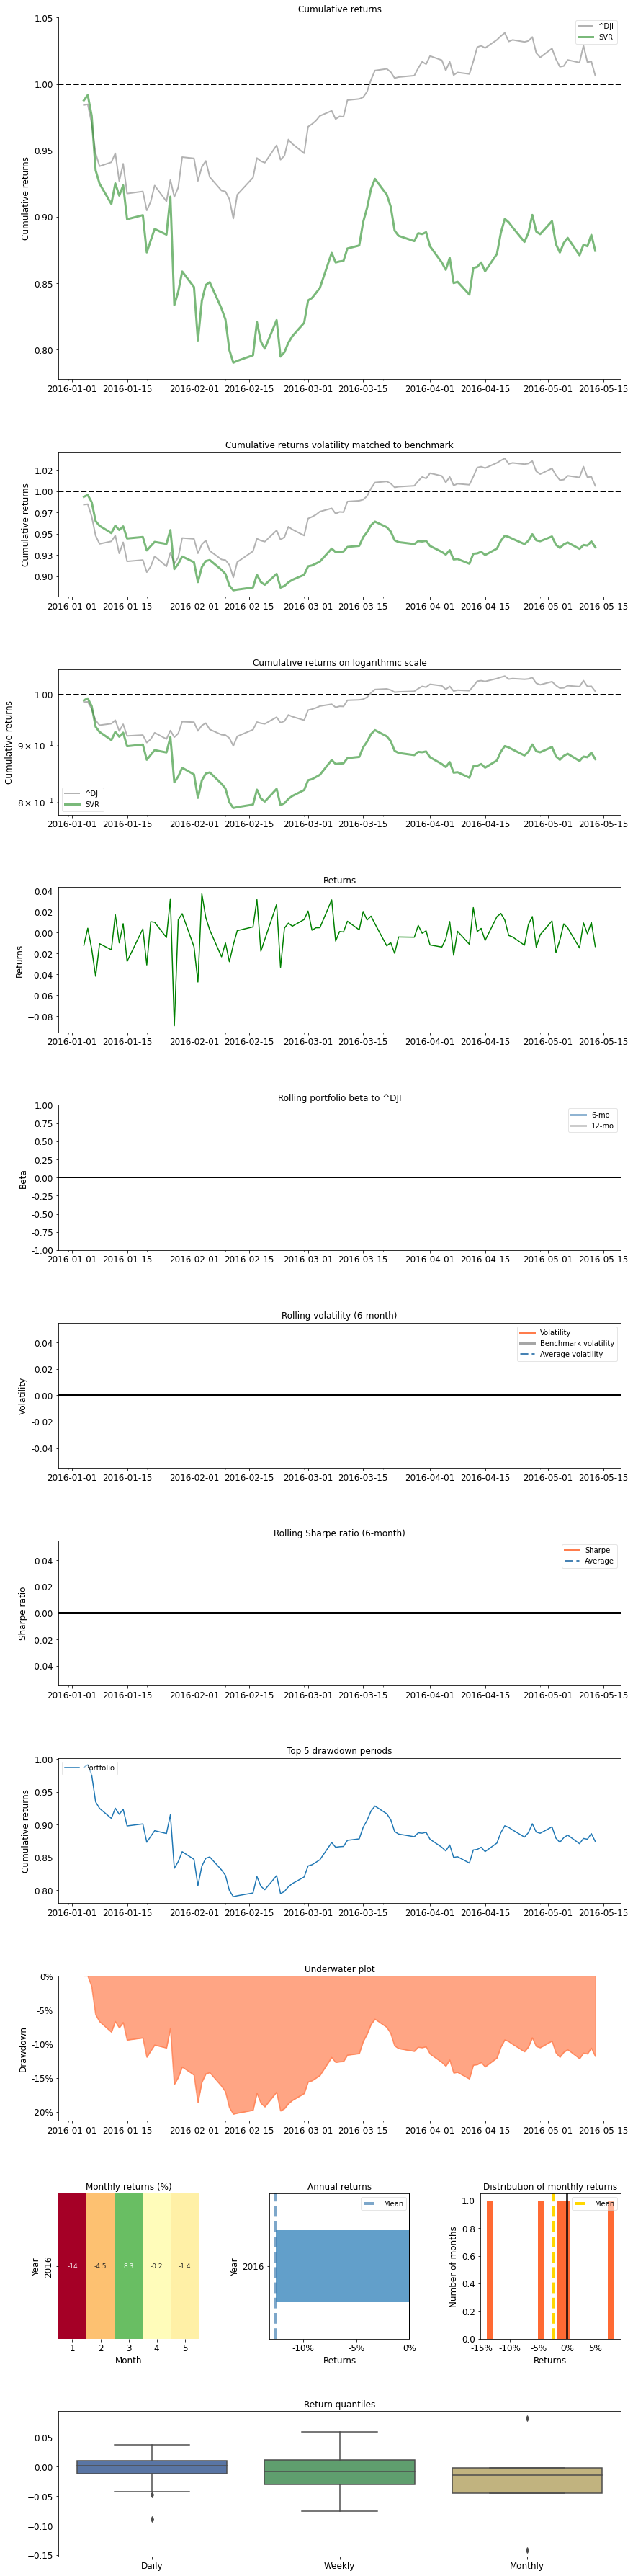

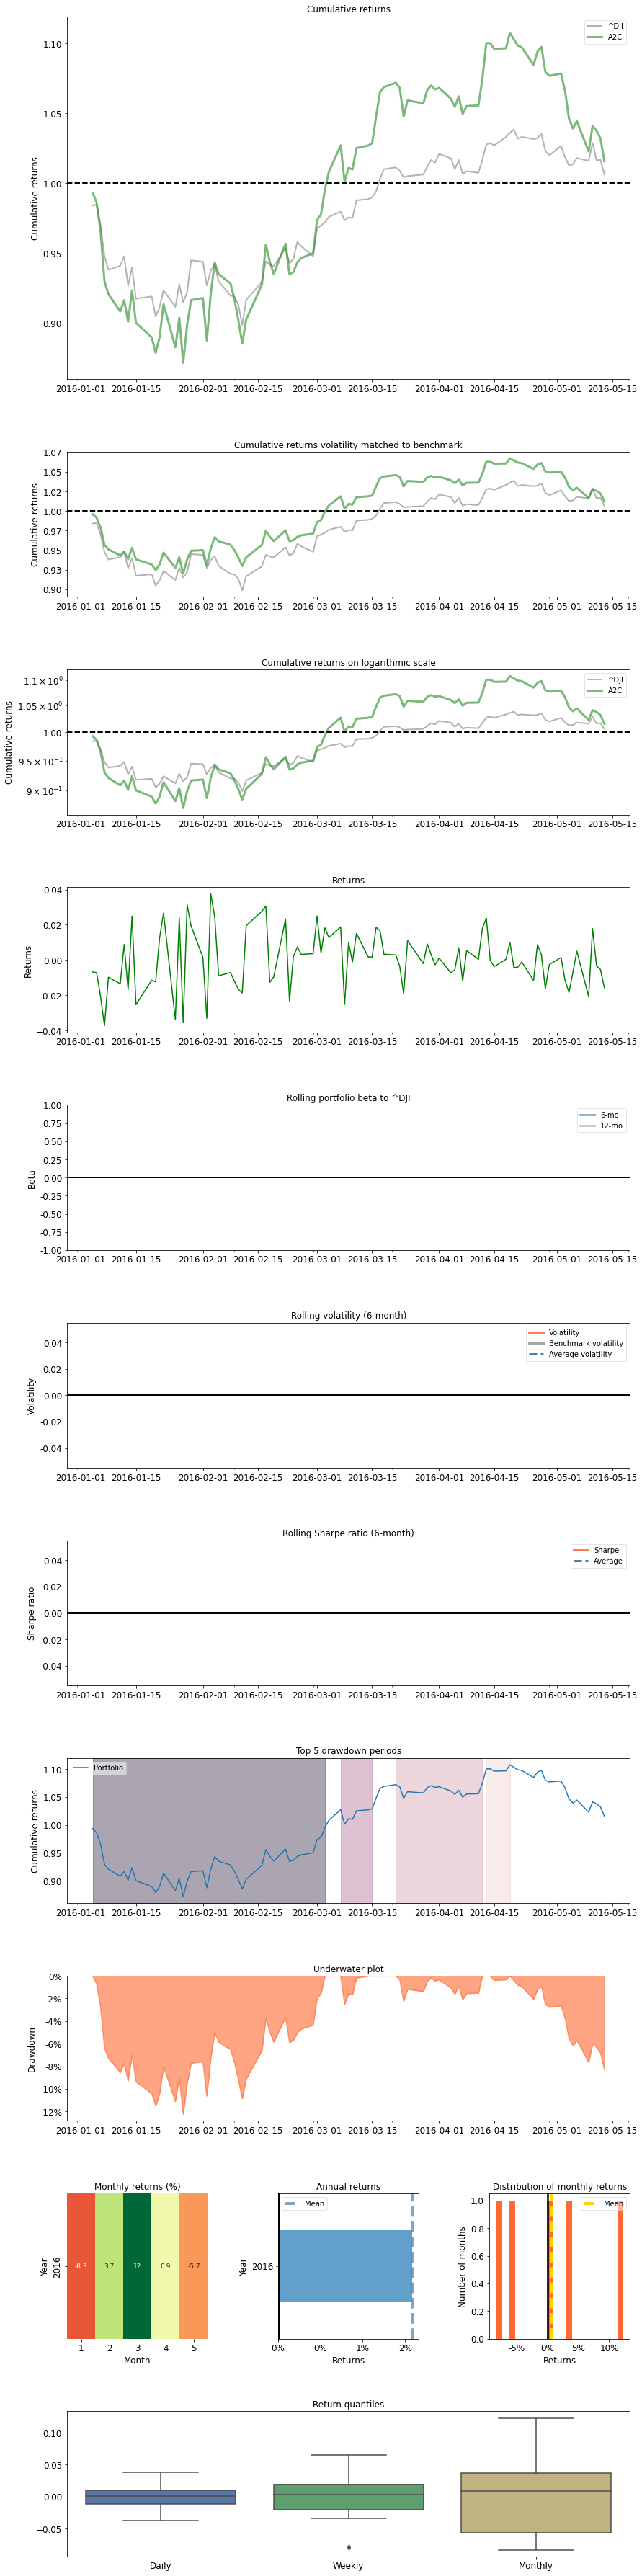

In [216]:
evaluator.backtest_plot()

### Model saving

In [ ]:
#Save model
svr.save_model("svr_model")

### Model loading

In [ ]:
#Load model
my_model = svr.load_model("svr_model")